In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from abc import ABC, abstractmethod

/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets.plagueworks_dataset import PlagueWorksDataset, DataLoader
resolution = (128, 128)
dataset = PlagueWorksDataset(split = "train", resolution = resolution, dataset_dir = "/Users/melkor/Documents/datasets")
def resample():
    loader = DataLoader(dataset, batch_size = 1, shuffle = True)
    for sample in loader:break
    return sample

In [3]:
import matplotlib.pyplot as plt
import torchvision
def visualize_image_grid(images, row, save_name = "image_grid"):
    plt.figure(save_name, frameon = False, figsize = (10,10));plt.cla()
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    comps_grid = torchvision.utils.make_grid(images,normalize=True,nrow=row).permute([1,2,0])

    plt.imshow(comps_grid.cpu().detach().numpy())
    plt.savefig("outputs/{}.png".format(save_name), bbox_inches='tight', pad_inches=0)

In [4]:
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights
from torchvision.utils import flow_to_image
import torchvision.transforms as T

def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1],
        ]
    )
    batch = transforms(batch)
    return batch

flow_predicter = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False)
flow_predicter = flow_predicter.eval()

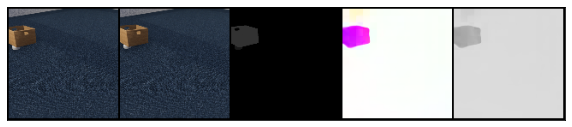

In [5]:
sample = resample()
img1 = sample["img1"]
img2 = sample["img2"]
mask = sample["masks"].unsqueeze(1).repeat(1,3,1,1) * 25.
list_of_flows = flow_predicter(
                preprocess(img1),
                preprocess(img2))
predicted_flows = list_of_flows[-1]
predicted_flows = flow_to_image(predicted_flows)
motion_strength = torch.norm(predicted_flows.permute(0,2,3,1).float() , dim = -1).unsqueeze(1).repeat(1,3,1,1) / 2.0

visualize_image_grid(
    torch.cat([img1 * 255., img2 * 255., mask, predicted_flows, motion_strength], dim = 0),
    row = 5)

In [6]:
from sgnet.grouping import SymbolicGrouper
model = SymbolicGrouper(resolution = (128,128), K = 7, long_range_ratio = 1.0)
model.load_state_dict(torch.load("checkpoints_/k7_save.pth"))
model = model.to("cpu")

In [11]:
import cv2 as cv
import numpy as np
# boundary restriction
w = 3
f = 0.19921875
boundary = torch.zeros([1, 128, 128])
boundary[:, 20: 100, 40:40+w] = f
boundary[:, 20: 100, 80:80+w] = f
boundary[:, 62: 62+w, 40:80+w] = f
boundary[:, 20: 20+w, 40:80+w] = f


gray_scale = (img1[0] * 255).permute(1,2,0).int().detach().numpy()
gray_scale = np.uint8(gray_scale)

edges = cv.Canny(gray_scale,100,200)

#boundary = torch.tensor(edges).unsqueeze(0) /255.
#plt.imshow(boundary[0])
boundary = None

0.19921875


In [12]:
outputs = model(img1, {}, boundary)

/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '


torch.Size([1, 128, 128, 30])


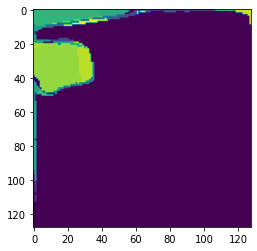

In [13]:
masks = outputs["masks"]
print(masks["objects"].shape)
from sgnet.utils import to_cc_masks
plt.figure("vis masks")
comps = to_cc_masks(masks["objects"][0], 1)
mask = torch.zeros([128,128])
for i in range(comps.shape[-1]):
    mask[comps[:,:,i]] = i+1
plt.imshow(mask)

torch.Size([1, 128, 128, 30])


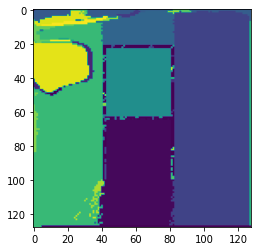

In [10]:
masks = outputs["masks"]
print(masks["objects"].shape)
from sgnet.utils import to_cc_masks
plt.figure("vis masks")
comps = to_cc_masks(masks["objects"][0], 1)
mask = torch.zeros([128,128])
for i in range(comps.shape[-1]):
    mask[comps[:,:,i]] = i+1
plt.imshow(mask)

51


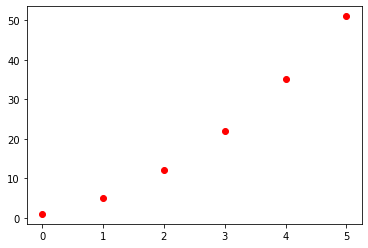

In [64]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
def penta(n):
    if n == 0: return 1
    return penta(n-1) + 4 + 3 * (n-1)

print(penta(5))

xs = torch.tensor([i for i in range(5)])[...,None]
ys = torch.tensor([penta(i) for i in range(5)])[...,None]

class Quad(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor([2.]))
        self.b = nn.Parameter(torch.tensor([3.]))
        self.c = nn.Parameter(torch.tensor([1.]))

    def forward(self, x):
        return self.a * x*x + self.b + x + self.c
model = Quad()

for i in range(6):
    plt.scatter([i],[penta(i)], color = "red")

In [96]:
def penta(n):
    return 3/2 * n*n + 5/2 * n + 1

print(penta(2))

12.0


In [67]:
optim = torch.optim.Adam(model.parameters(), lr = 2e-1)
for epoch in range(1000):
    optim.zero_grad()
    p = model(xs.float())
    loss = nn.functional.mse_loss(p.float(), ys.float())
    loss.backward()
    optim.step()
print(loss)
print(model.a, model.b, model.c)

tensor(0.3621, grad_fn=<MseLossBackward0>)
Parameter containing:
tensor([1.8448], requires_grad=True) Parameter containing:
tensor([1.9655], requires_grad=True) Parameter containing:
tensor([-0.0345], requires_grad=True)
